# 1. DATA

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
# 데이터 읽어오기
data_path = os.getcwd() +'/data/'
data = data_path + 'train.csv'
sub = data_path + 'test.csv'

In [3]:
# 데이터 확인
data = pd.read_csv(data)
# data.keys()
print('train data dim : {}'.format(data.shape))

train data dim : (15035, 21)


In [4]:
# 데이터 확인
sub = pd.read_csv(sub)
# sub.keys()
print('sub data dim : {}'.format(sub.shape))

sub data dim : (6468, 20)


In [5]:
# target 데이터 분리 
print(set(data) - set(sub))
y = data['price']
data = data.drop(['price'], axis=1)

{'price'}


In [6]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

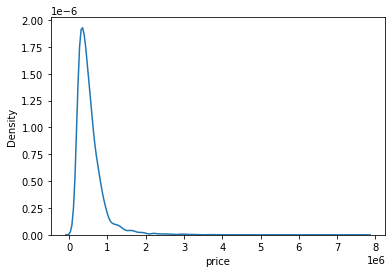

In [7]:
sns.kdeplot(y)

In [8]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

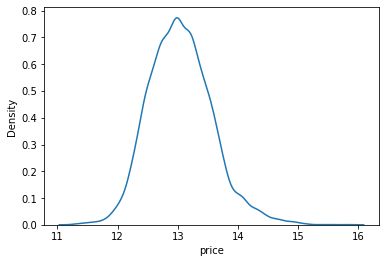

In [9]:
sns.kdeplot(y)
plt.show()

In [10]:
train_len = len(data)
print(train_len)
data = pd.concat((data, sub), axis=0)

15035


In [11]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 2. EDA

<AxesSubplot:>

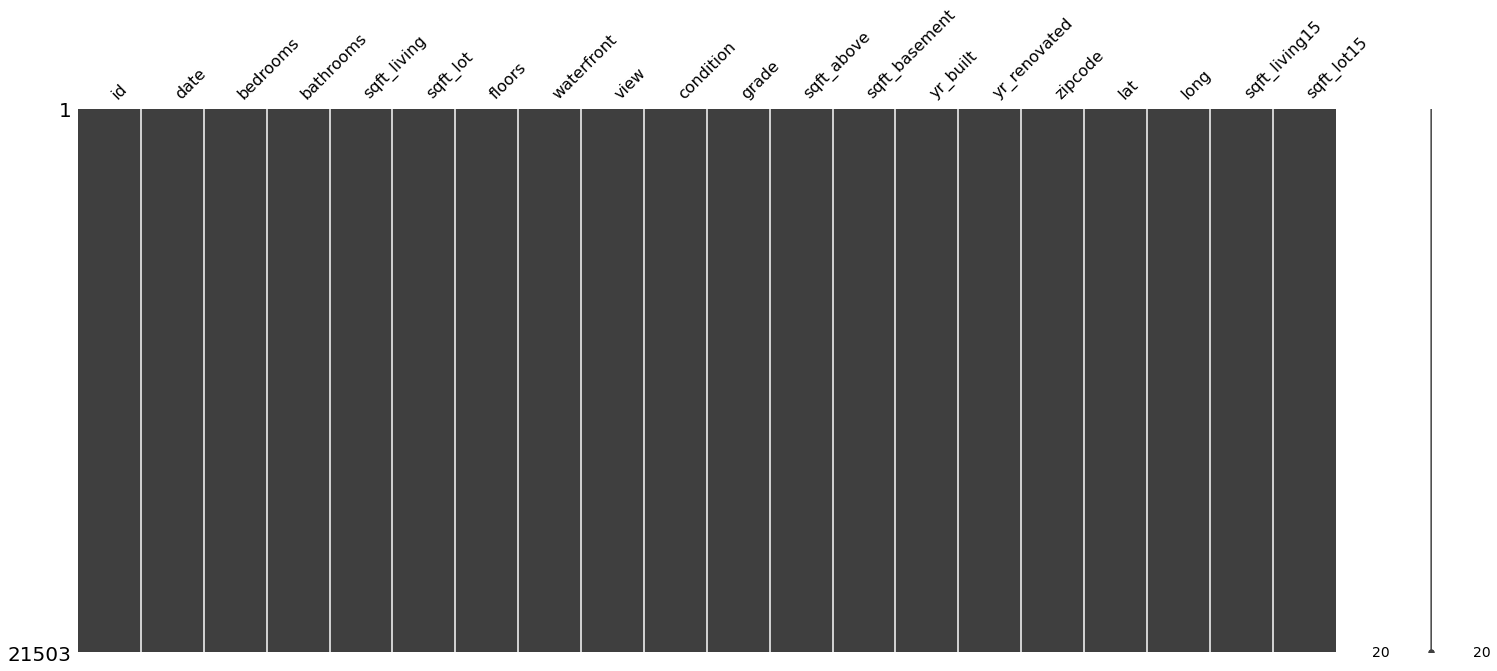

In [12]:
# 결측치 확인
msno.matrix(data)

In [13]:
# 결측치 확인
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [14]:
# 데이터 타입 변경
# data['date'] : dtype: object -> dtype: int64
print(data['date']) # 20141013T000000
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)
print(data['date'])

0       20141013T000000
1       20150225T000000
2       20150218T000000
3       20140627T000000
4       20150115T000000
             ...       
6463    20140626T000000
6464    20150126T000000
6465    20150219T000000
6466    20140623T000000
6467    20150116T000000
Name: date, Length: 21503, dtype: object
0       201410
1       201502
2       201502
3       201406
4       201501
         ...  
6463    201406
6464    201501
6465    201502
6466    201406
6467    201501
Name: date, Length: 21503, dtype: int64


In [15]:
# data['id'] 삭제
sub_id = data['id'][train_len:]
del data['id']

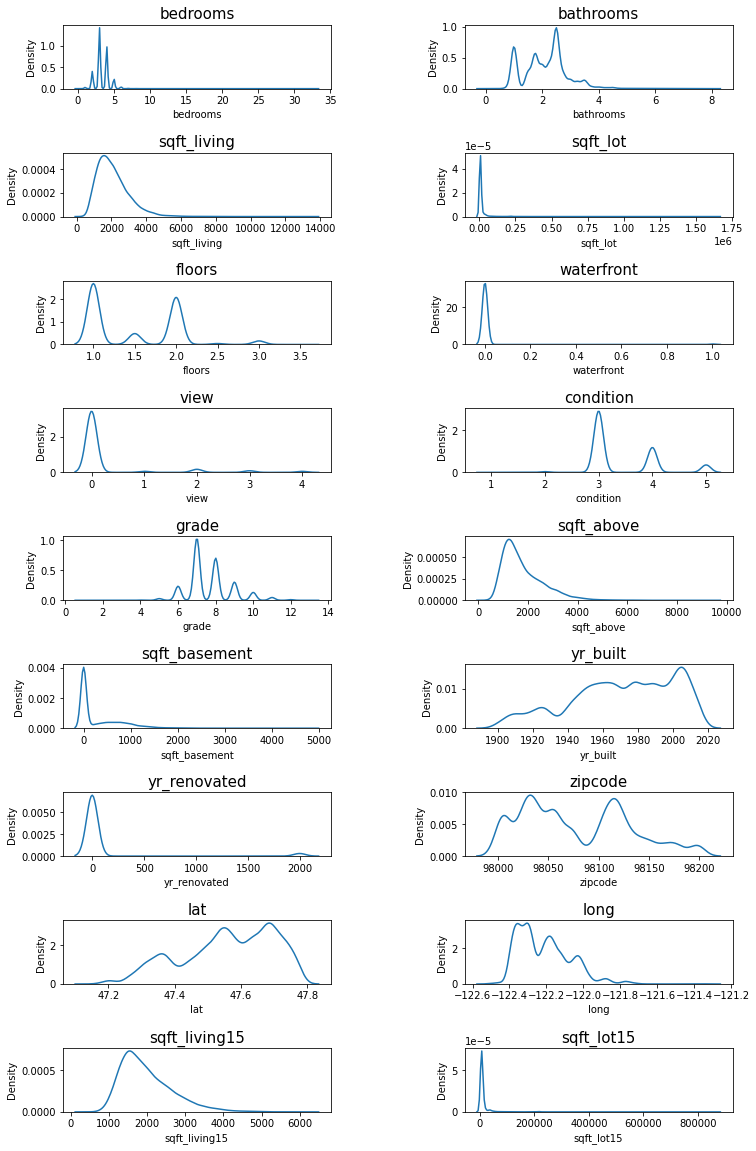

In [16]:
#데이터 분포 확인
def check_distribution(data, col=1):
    row = int(data.shape[1]/col)
    count = 1
    columns = data.columns
    
    fig, ax = plt.subplots(row, col, figsize=(12,20))
    
    for i in range(row):
        for j in range(col):
            sns.kdeplot(data=data[columns[count]], ax=ax[i][j])
            ax[i][j].set_title(columns[count], fontsize=15)
            count += 1
            if count == data.shape[1]:
                break
    plt.subplots_adjust(wspace=0.5, hspace=1)
    
check_distribution(data, col=2)

In [17]:
# log scaling(로그 변환)

# skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'waterfront',
                'view','sqft_above', 'sqft_basement']


def log_scaling(data, skew_columns):
    for c in skew_columns:
        data[c] = np.log1p(data[c].values)
    return data

log_scaling(data, skew_columns)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0.0,0.0,3,7,7.074117,0.000000,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0.0,0.0,3,6,6.647688,0.000000,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0.0,0.0,3,8,7.427144,0.000000,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0.0,0.0,3,7,7.447751,0.000000,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0.0,0.0,3,7,6.966967,0.000000,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,1.386294,1.75,7.313887,9.390075,1.0,0.0,0.0,3,6,7.313887,0.000000,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,1.386294,2.00,7.307202,7.027315,3.0,0.0,0.0,3,8,7.307202,0.000000,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,1.386294,2.50,7.178545,7.166266,2.0,0.0,0.0,3,8,7.074117,4.875197,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,1.098612,0.75,6.928538,7.208600,2.0,0.0,0.0,3,7,6.928538,0.000000,2009,0,98144,47.5944,-122.299,1020,2007


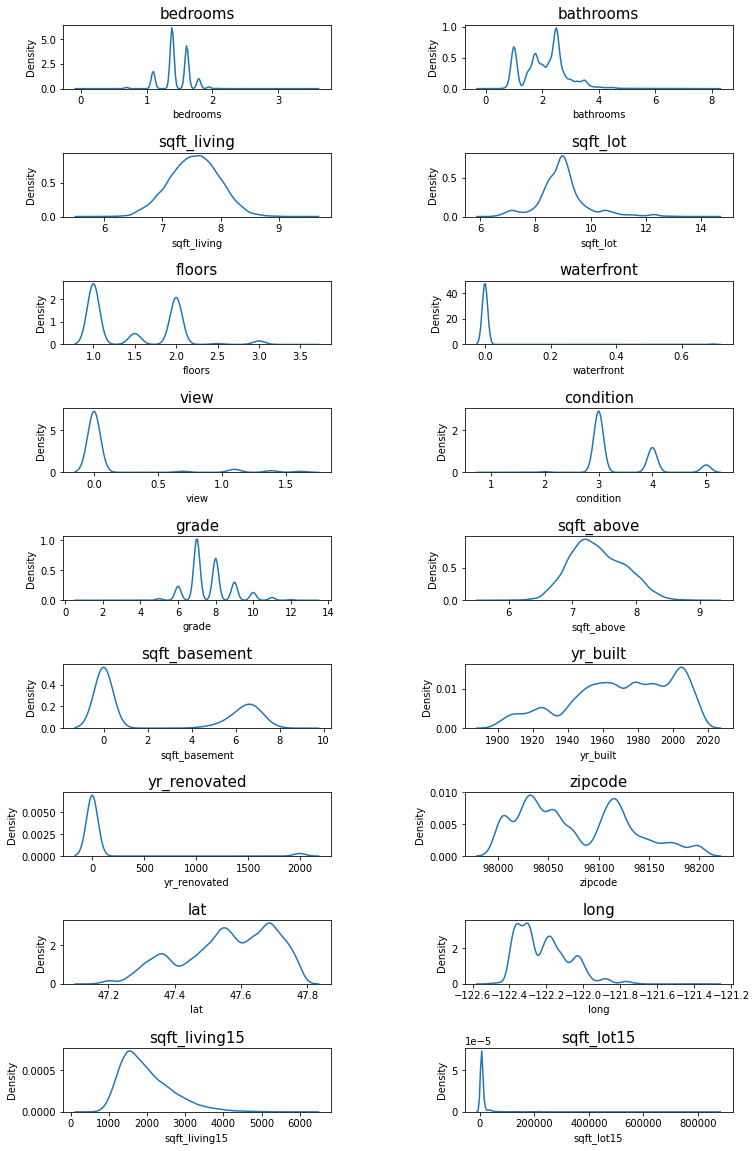

In [18]:
# 데이터 분산 재확인
check_distribution(data, col=2)

In [19]:
# normalization
# use robustscaler: minimize the impact of outliers
# 효과 있을까?
def robust_scale(df):
    robustscaler = RobustScaler()
    robustscaler.fit(df)

    df = robustscaler.transform(df) 
    return df

robust_scale(data)

array([[ 0.        ,  0.        , -1.66666667, ..., -0.13300493,
        -0.56818182, -0.39518556],
       [ 0.96842105, -1.28922423, -1.66666667, ..., -0.01477833,
         1.        ,  0.088666  ],
       [ 0.96842105,  0.        , -0.33333333, ...,  0.91133005,
        -0.04545455, -0.02347041],
       ...,
       [ 0.96842105,  0.        ,  0.33333333, ..., -0.8817734 ,
        -0.57954545, -1.27482447],
       [-0.04210526, -1.28922423, -2.        , ..., -0.33990148,
        -0.93181818, -1.12597793],
       [ 0.95789474,  0.        ,  0.33333333, ...,  0.79310345,
        -0.48863636, -1.27041123]])

In [20]:
# train, test 데이터 분리 (x=train, y=sub)
x = data.iloc[:train_len, :] 
sub = data.iloc[train_len:, :] 
print( 'x', x.shape, 'sub', sub.shape)

x (15035, 19) sub (6468, 19)


# 3. Model

In [21]:
random_state = 2024

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

lightgbm = LGBMRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)
gboost = GradientBoostingRegressor(random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, 
          {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}, 
          {'model':rdforest, 'name':'RandomForestRegressor'}]


In [22]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=2024).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))
        
get_cv_score(models)
'''
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
Model GradientBoosting CV score : 0.8594
Model XGBoost CV score : 0.8861
Model LightGBM CV score : 0.8819
Model RandomForestRegressor CV score : 0.8693

skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'waterfront',
                'view','sqft_above', 'sqft_basement']
Model GradientBoosting CV score : 0.8594
Model XGBoost CV score : 0.8861
Model LightGBM CV score : 0.8819
Model RandomForestRegressor CV score : 0.8693
-> 차이 없음

normalization 사용 
Model GradientBoosting CV score : 0.8796
Model XGBoost CV score : 0.8973
Model LightGBM CV score : 0.9025
Model RandomForestRegressor CV score : 0.8859
-> 차이 있음
'''

Model GradientBoosting CV score : 0.8796
Model XGBoost CV score : 0.8973
Model LightGBM CV score : 0.9025
Model RandomForestRegressor CV score : 0.8859


"\nskew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']\nModel GradientBoosting CV score : 0.8594\nModel XGBoost CV score : 0.8861\nModel LightGBM CV score : 0.8819\nModel RandomForestRegressor CV score : 0.8693\n\nskew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'waterfront',\n                'view','sqft_above', 'sqft_basement']\nModel GradientBoosting CV score : 0.8594\nModel XGBoost CV score : 0.8861\nModel LightGBM CV score : 0.8819\nModel RandomForestRegressor CV score : 0.8693\n-> 차이 없음\n\nnormalization 사용 \nModel GradientBoosting CV score : 0.8796\nModel XGBoost CV score : 0.8973\nModel LightGBM CV score : 0.9025\nModel RandomForestRegressor CV score : 0.8859\n-> 차이 있음\n"

In [23]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [24]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
print(y_pred)

6468
[13.12109246 13.0178501  14.08051373 ... 13.03127083 12.71623304
 12.99256396]


In [25]:
# def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
#     # GridSearchCV 모델로 초기화
#     grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
#                               cv=5, verbose=verbose, n_jobs=n_jobs)

#     # 모델 fitting
#     grid_model.fit(train, y)

#     # 결과값 저장
#     params = grid_model.cv_results_['params']
#     score = grid_model.cv_results_['mean_test_score']

#     # 데이터 프레임 생성
#     results = pd.DataFrame(params)
#     results['score'] = score

#     # RMSLE 값 계산 후 정렬
#     results['RMSLE'] = np.sqrt(-1 * results['score'])
#     results = results.sort_values('RMSLE')

#     return results

In [26]:
# param_grid = {
#     'n_estimators': [50, 100],
#     'max_depth': [1, 10],
# }

# # model = LGBMRegressor(random_state=random_state)
# for model in models:
#     print(model.det())
#     my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=5)
#     grid_model = GridSearchCV(model, param_grid=param_grid, \
#                         scoring='neg_mean_squared_error', \
#                         cv=5, verbose=1, n_jobs=5)
#     grid_model.fit(x, y)    

In [27]:
# grid_model = GridSearchCV(model, param_grid=param_grid, \
#                         scoring='neg_mean_squared_error', \
#                         cv=5, verbose=1, n_jobs=5)

# grid_model.fit(x, y)

In [28]:
# params = grid_model.cv_results_['params']
# params

In [29]:
# score = grid_model.cv_results_['mean_test_score']
# score

In [30]:
# results = pd.DataFrame(params)
# results['score'] = score

# results

In [31]:
# results['RMSE'] = np.sqrt(-1 * results['score'])
# results

# 4. Submission

In [32]:
submission = pd.read_csv(data_path+'/sample_submission.csv')
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [33]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})
sub.head()

,id,price
0,15035,13.121092
1,15036,13.017850
2,15037,14.080514
3,15038,12.629476
4,15039,12.672619


In [34]:
submission_csv_path = '{}/submission_sy_{}.csv'.format(data_path,'0827')
sub.to_csv(submission_csv_path, index=False)